Bseline model from https://github.com/CVxTz/ECG_Heartbeat_Classification/blob/master/code/baseline_mitbih.py

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras import backend as k
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from keras.initializers import glorot_uniform

In [12]:
df_train = pd.read_csv("../input/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("../input/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]
Y_test = np.array(df_test[187].values).astype(np.int8)

In [39]:
# Pieces of code copied from 2dResNet: https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Convolution1D(filters=F1, kernel_size=3, padding='same', name=conv_name_base + 'a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Convolution1D(filters=F2, kernel_size=f, padding='same', name=conv_name_base + 'b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Convolution1D(filters=F3, kernel_size=1, padding='same', name=conv_name_base + 'c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Convolution1D(filters=F3, kernel_size=1, padding='valid', name=conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [41]:
# Pieces of code copied from 2dResNet: https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Convolution1D(filters = F1, kernel_size = 3, activation=activations.relu, padding = 'same', name = conv_name_base + 'a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'a')(X)
#     X = Activation('relu')(X)
    
    # Second component of main path
    X = Convolution1D(filters = F2, kernel_size = f, activation=activations.relu, padding = 'same', name = conv_name_base + 'b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'b')(X)
#     X = Activation('relu')(X)

    # Third component of main path 
    X = Convolution1D(filters = F3, kernel_size = 1, activation=activations.relu, padding = 'same', name = conv_name_base + 'c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [45]:
# Pieces of code copied from 2dResNet: https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff
def get_model():
    nclass = 5
    inp = Input(shape=(187, 1))
    
    # Stage 1
    img_1 = Convolution1D(16, 3, name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(inp)
    img_1 = BatchNormalization(name = 'bn_conv1')(img_1)
    img_1 = Activation('relu')(img_1)
    img_1 = MaxPool1D(pool_size=3, strides=2)(img_1)

    # Stage 2
    img_1 = convolutional_block(img_1, f = 3, filters = [16, 16, 64], stage = 2, block='a', s = 1)
    img_1 = identity_block(img_1, 3, [16, 16, 64], stage=2, block='b')
    img_1 = identity_block(img_1, 3, [16, 16, 64], stage=2, block='c')

    # Stage 3
    img_1 = convolutional_block(img_1, f=3, filters=[32, 32, 64], stage=3, block='a', s=2)
    img_1 = identity_block(img_1, 3, [32, 32, 64], stage=3, block='b')
    img_1 = identity_block(img_1, 3, [32, 32, 64], stage=3, block='c')
    img_1 = identity_block(img_1, 3, [32, 32, 64], stage=3, block='d')

    # Stage 4
    img_1 = convolutional_block(img_1, f=3, filters=[32, 32, 128], stage=4, block='a', s=2)
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='b')
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='c')
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='d')
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='e')
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='f')

    # Stage 5
    img_1 = convolutional_block(img_1, f=3, filters=[16, 16, 64], stage=5, block='a', s=2)
    img_1 = identity_block(img_1, 3, [16, 16, 64], stage=5, block='b')
    img_1 = identity_block(img_1, 3, [16, 16, 64], stage=5, block='c')

    # AVGPOOL
    img_1 = GlobalMaxPool1D()(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model


In [51]:
model = get_model()
file_path = "res_cnn_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
# callbacks_list = [checkpoint, early, redonplat]  # early
callbacks_list = [early, redonplat]  # checkpoint returns an error for ResCNN

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.conv1d_290), but
are not present in its tracked objects:
  <tf.Variable 'conv1/kernel:0' shape=(3, 1, 16) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_290), but
are not present in its tracked objects:
  <tf.Variable 'conv1/bias:0' shape=(16,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.conv1d_291), but
are not present in its tracked objects:
  <tf.Variable 'res2a_brancha/kernel:0' shape=(3, 16, 16) dtype=float32>
It is possible that this is in

In [9]:
# RUN the Model

In [52]:
model.fit(X, Y, epochs=5, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/5
2463/2463 [==============================] - 170s 68ms/step - loss: 0.3311 - acc: 0.9041 - val_loss: 0.2532 - val_acc: 0.9267
Epoch 2/5
2463/2463 [==============================] - 178s 72ms/step - loss: 0.2174 - acc: 0.9396 - val_loss: 0.1909 - val_acc: 0.9474
Epoch 3/5
2463/2463 [==============================] - 175s 71ms/step - loss: 0.1875 - acc: 0.9465 - val_loss: 0.1813 - val_acc: 0.9479
Epoch 4/5
2463/2463 [==============================] - 176s 71ms/step - loss: 0.1703 - acc: 0.9519 - val_loss: 0.1703 - val_acc: 0.9504
Epoch 5/5
2463/2463 [==============================] - 174s 71ms/step - loss: 0.1604 - acc: 0.9550 - val_loss: 0.1556 - val_acc: 0.9576


In [53]:
# model.load_weights(file_path)
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(Y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.7014601299677512 
Test accuracy score : 0.9565594737803764 


Normalized confusion matrix


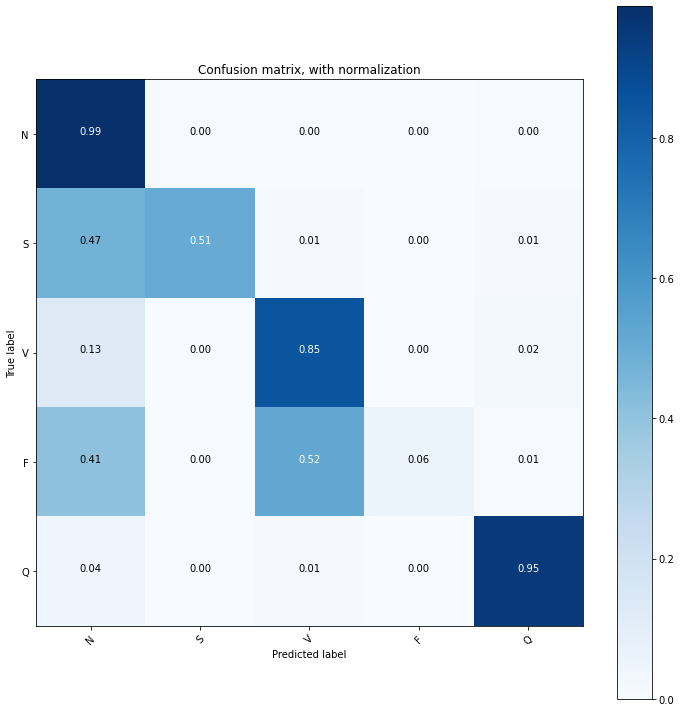

In [55]:
# taken from https://www.kaggle.com/gregoiredc/arrhythmia-on-ecg-classification-using-cnn

from tensorflow.keras.utils import to_categorical

target_test=df_test[187]
y_test=to_categorical(target_test)

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), pred_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.savefig('confusion_matrix_CNN_baseline_mitbih.png')
plt.show()

<Figure size 432x288 with 0 Axes>